### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempPropSelection/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 247 ms, sys: 81.3 ms, total: 328 ms
Wall time: 345 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
#treated[treated.PERS_ID == '2567120'][['MYR', 'ALLOW_IP', 'ALLOW_ER', 'Acute-bin']]

In [10]:
#survTr

In [11]:
%%time
after = 0
grace = 1
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True)


CPU times: user 4.92 s, sys: 32.4 ms, total: 4.96 s
Wall time: 4.95 s


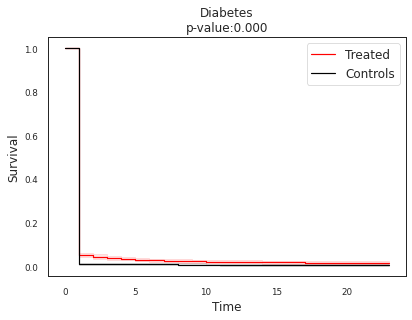

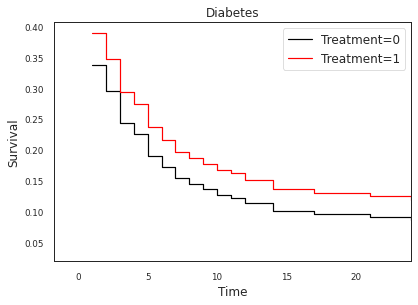

In [12]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [13]:
lrsumm

test_statistic         p   -log2(p)
Diabetes       22.599031  0.000002  18.934563

In [14]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.071           0.128       -0.557    0.577
Gender               0.044           0.036        1.222    0.222
Total Cost           0.023           0.008        2.970    0.003
Tobacco use         -0.008           0.053       -0.156    0.876
Obesity              0.009           0.041        0.217    0.828
Hypertension         0.039           0.045        0.860    0.390
Hypothyroid         -0.008           0.060       -0.134    0.893
Disease Count        0.466           0.175        2.663    0.008
Treatment           -0.142           0.036       -3.926    0.000

### ER

In [15]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True)


CPU times: user 5 s, sys: 16.1 ms, total: 5.01 s
Wall time: 5.01 s


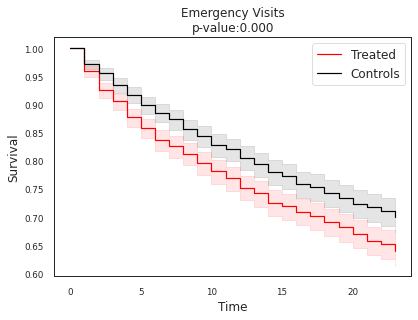

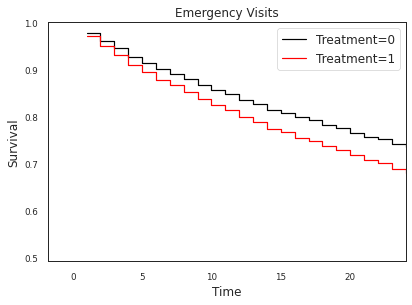

In [17]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [18]:
lrsumm

test_statistic         p   -log2(p)
Emergency Visits       13.987189  0.000184  12.407532

In [19]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -2.057           0.216       -9.520    0.000
Gender              -0.155           0.061       -2.520    0.012
Total Cost           0.034           0.014        2.435    0.015
Tobacco use          0.314           0.079        3.981    0.000
Obesity             -0.078           0.068       -1.151    0.250
Hypertension        -0.051           0.078       -0.660    0.509
Hypothyroid         -0.166           0.098       -1.690    0.091
Disease Count        2.890           0.285       10.135    0.000
Treatment            0.220           0.061        3.603    0.000

### IP

In [20]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True)


CPU times: user 4.99 s, sys: 8.11 ms, total: 5 s
Wall time: 5 s


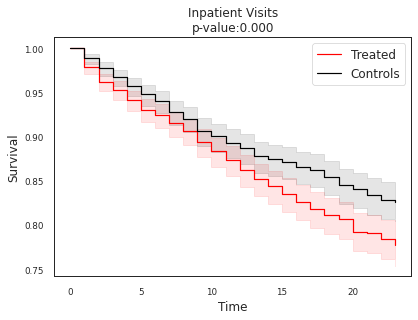

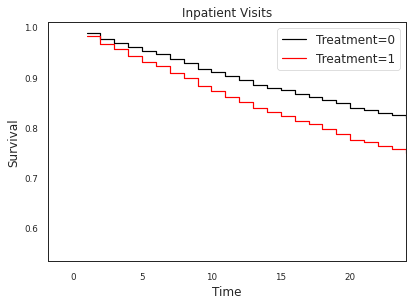

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [23]:
lrsumm

test_statistic         p   -log2(p)
Inpatient Visits       20.724563  0.000005  17.524723

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.338           0.287       -1.177    0.239
Gender               0.072           0.077        0.938    0.348
Total Cost           0.099           0.020        4.918    0.000
Tobacco use          0.130           0.098        1.323    0.186
Obesity             -0.383           0.083       -4.611    0.000
Hypertension         0.013           0.098        0.128    0.898
Hypothyroid         -0.159           0.113       -1.413    0.158
Disease Count        4.477           0.311       14.378    0.000
Treatment            0.367           0.077        4.771    0.000

### Acute Care IP OR ER

In [25]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True)


CPU times: user 5 s, sys: 0 ns, total: 5 s
Wall time: 5 s


In [27]:
treated[treated.PERS_ID == '2582630'][['IP_BIN2','ER_BIN2']]

IP_BIN2  ER_BIN2
93       0.0      0.0
94       0.0      0.0
95       0.0      0.0
96       0.0      0.0
97       0.0      0.0
98       0.0      0.0
99       0.0      0.0
100      0.0      0.0
101      0.0      0.0
102      0.0      0.0
103      0.0      0.0
104      0.0      0.0
105      0.0      0.0
106      0.0      0.0
107      0.0      0.0
108      0.0      0.0
109      0.0      0.0
110      0.0      0.0
111      0.0      0.0
112      0.0      0.0
113      0.0      0.0
114      0.0      0.0
115      0.0      0.0
116      0.0      1.0
117      0.0      1.0
118      0.0      0.0
119      0.0      0.0
120      0.0      0.0
121      0.0      0.0
122      0.0      0.0
123      0.0      0.0
124      0.0      0.0
125      0.0      0.0
126      0.0      0.0
127      0.0      0.0
128      0.0      0.0
129      0.0      0.0
130      0.0      0.0
131      0.0      0.0
132      0.0      0.0
133      0.0      0.0
134      0.0      0.0
135      0.0      0.0
136      0.0      0.0
137      0.0      1.0
138      0.0      1.0
139      0.0      0.0
140      0.0      0.0
141      0.0      0.0
142      0.0      0.0
143      0.0      0.0
144      0.0      0.0

In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
1     2578414   4  1      0     0.0     1.0        1               87   
5     2582630  23  1      0     0.0     0.0        0               84   
7     2583925  27  1      0     0.0     0.0        0               85   
8     2588409  49  1      0     0.0     0.0        0               82   
10    2590558   4  1      0     0.0     0.0        0               81   
...       ...  .. ..    ...     ...     ...      ...              ...   
1614  4378736   7  1      0     0.0     2.0        2               46   
1615  4386027   2  1      0     0.0     1.0        1               27   
1616  4387489   5  1      0     0.0     0.0        0               63   
1619  4399083   1  1      1     2.0     3.0        4               25   
1626  5029134   1  1      1     1.0     1.0        1               42   

      ALLOW_AMT  ALLOW_ER  ...  ER_BIN6  ER_C  IP_BIN  IP_BIN2  IP_BIN6  IP_C  \
1          1996      0.00  ...      0.0     0       0      0.0      1.0     1   
5           306      0.00  ...      0.0     0       0      0.0      0.0     0   
7          2103      0.00  ...      0.0     0       0      0.0      0.0     0   
8           327      0.00  ...      0.0     0       0      0.0      0.0     0   
10         1362      0.00  ...      0.0     0       0      0.0      0.0     0   
...         ...       ...  ...      ...   ...     ...      ...      ...   ...   
1614        998      0.00  ...      1.0     1       0      0.0      2.0     2   
1615        191      0.00  ...      0.0     0       0      0.0      1.0     1   
1616       1715      0.00  ...      0.0     0       0      0.0      0.0     0   
1619        249    174.22  ...      2.0     3       0      0.0      1.0     1   
1626      12883   1264.24  ...      1.0     1       0      0.0      0.0     0   

      MBR_GNDR     MYR  PREGNANCY  Treatment  
1          1.0  201707        0.0          1  
5          0.0  201604        0.0          1  
7          0.0  201710        0.0          1  
8          0.0  201602        0.0          1  
10         0.0  201604        0.0          1  
...        ...     ...        ...        ...  
1614       1.0  201904        0.0          1  
1615       1.0  201906        0.0          1  
1616       0.0  201903        0.0          1  
1619       0.0  202004        0.0          1  
1626       0.0  202004        0.0          1  

[787 rows x 92 columns]

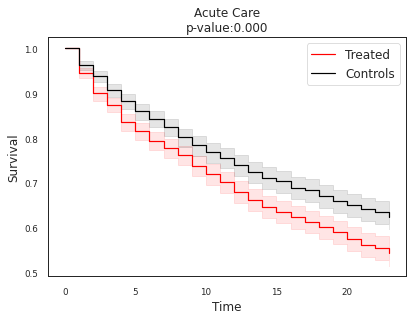

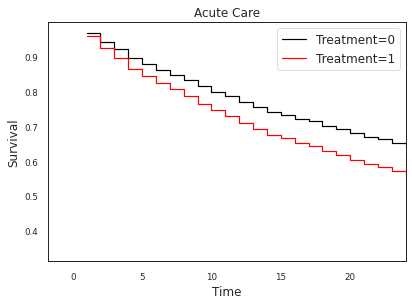

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [30]:
lrsumm

test_statistic             p   -log2(p)
Acute Care       24.207249  8.650605e-07  20.140696

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.546           0.197       -7.866    0.000
Gender              -0.106           0.055       -1.923    0.054
Total Cost           0.057           0.013        4.397    0.000
Tobacco use          0.248           0.072        3.468    0.001
Obesity             -0.132           0.060       -2.195    0.028
Hypertension        -0.055           0.069       -0.804    0.421
Hypothyroid         -0.178           0.086       -2.064    0.039
Disease Count        3.394           0.248       13.668    0.000
Treatment            0.273           0.054        5.014    0.000

### Load all Log Rank Sums in a matrix

In [32]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [33]:
df2

logRank statistic       p-value  RMST difference
Diabetes                  31.782343  1.724534e-08         0.376650
Emergency Visits          13.987189  1.840605e-04        -1.085022
Inpatient Vistis          20.724563  5.303136e-06        -0.632135
Acute Care                24.207249  8.650605e-07        -1.308579